# Ontology
---

Two key variables will be included: Exposure and Label. 

The variable Exposure will be used to categorize patients based on their dosage of simvastatin, where an exposure value of 1 indicates a low dose and a value of 2 indicates a high dose.

The variable Label will represent the lung cancer outcome, with a value of 0 signifying that the patient did not develop lung cancer and a value of 1 indicating that lung cancer was diagnosed. These variables will be central to the analysis, enabling the investigation of the association between simvastatin dosage and lung cancer development.


Forming the basis:

Response variable is label, part of the feature is the Exposure, along with the rest of the features.

# Question 1: Weighting for Covariate Balance
---

1. Apply propensity score weighting to adjust for potential confounders when
comparing exposure groups. Discuss the rationale behind using propensity
scores to create comparable groups and mitigate selection bias in observational
studies.

2. Visualize the balance of propensity scores between exposure groups using
density plots, reflecting on how effective the weighting procedure has been in
adjusting the groups

## Step 0: Install the necessary packages and load them
---

In [1]:
install.packages("dplyr")
install.packages("fastDummies")
install.packages("tableone")
install.packages("MatchIt")
install.packages("survey")  # For weighting analysis
install.packages("cobalt")
install.packages("WeightIt")
install.packages("ggplot2")
install.packages("patchwork")
install.packages("cowplot")


The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages are in
	/var/folders/nv/sjj_9gb52674c8ktybqghkm80000gq/T//Rtmp3ULDIW/downloaded_packages

The downloaded binary packages 

In [78]:
library(dplyr)
library(fastDummies)
library(tableone)
library(MatchIt)
library(survey)
library(cobalt)
library(WeightIt)
library(ggplot2)
library(ggplot2)
library(patchwork)
library(cowplot)

## Step 1: Load the dataset
---

In [79]:
load("cleaned_data.RData")

## Step 2: Check the content of the data
---

In [80]:
ls()

[1] "Df_regression_unique" "bal"                  "combined_plot"       
[4] "covariates"           "plot_after"           "plot_before"         
[7] "propensity_model"

## Step 3: Check the class of the data
---

In [81]:
class(Df_regression_unique)

[1] "data.frame"

## Step 4: Calculate Propensity Scores
---

Define a logistic regression model for the propensity scores, using covariates (potential confounders) to predict group membership (exposure)


In [82]:
tail(Df_regression_unique)

,label,age,gender_female,smoking_status,alcohol_assessment,bmi,chronic_obstructive_bronchitis,pneumonia,asthma,dvt,⋯,hawaiian,native,no_cancer,stage4,stage1a,stage2a,stage3a,stage1b,stage2b,stage3b
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5933,0,53,1,0,1,29.66,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
5934,0,70,0,1,1,30.06,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
5935,0,70,0,0,1,31.07,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
5936,1,75,0,0,1,29.60,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
5937,0,59,0,0,1,27.30,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0
5938,0,46,1,1,1,27.60,0,0,0,0,⋯,0,0,1,0,0,0,0,0,0,0


In [83]:
# Checking column names
colnames(Df_regression_unique)

[1] "label"                          "age"                           
 [3] "gender_female"                  "smoking_status"                
 [5] "alcohol_assessment"             "bmi"                           
 [7] "chronic_obstructive_bronchitis" "pneumonia"                     
 [9] "asthma"                         "dvt"                           
[11] "Followup"                       "statin"                        
[13] "asian"                          "white"                         
[15] "black"                          "hawaiian"                      
[17] "native"                         "no_cancer"                     
[19] "stage4"                         "stage1a"                       
[21] "stage2a"                        "stage3a"                       
[23] "stage1b"                        "stage2b"                       
[25] "stage3b"

##### <b> <font color='red'>Important Notes:</font> </b> 
---

I only included the following columns:

label','age','gender_female','smoking_status','alcohol','bmi','chronic_obstructive_bronchitis'
,'pneumonia','asthma','dvt','Followup','statin','asian','white','black','hawaiian','native'

I included the race because I also want to know if racial characteristics also affect lung cancer (Example esophageal cancer is considered a relatively common type of cancer in Japan compared to other asian countries)

In [84]:
# Fit a propensity score model
propensity_model <- glm( `label` ~ `age`+`gender_female`+`smoking_status`+`alcohol_assessment`+`bmi`+`chronic_obstructive_bronchitis`+`pneumonia`+`asthma`+`dvt`+`Followup`+`statin`+`asian`+`white`+`black`+`hawaiian`+`native`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)

In [85]:
# Extract propensity scores
Df_regression_unique$propensity_score <- predict(propensity_model, type = "response")

## Step 5: Plot the propensity score of each patient along with weights
---

In [86]:
tail(Df_regression_unique)

,label,age,gender_female,smoking_status,alcohol_assessment,bmi,chronic_obstructive_bronchitis,pneumonia,asthma,dvt,⋯,native,no_cancer,stage4,stage1a,stage2a,stage3a,stage1b,stage2b,stage3b,propensity_score
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5933,0,53,1,0,1,29.66,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0.01643594
5934,0,70,0,1,1,30.06,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0.60717267
5935,0,70,0,0,1,31.07,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0.16577225
5936,1,75,0,0,1,29.60,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0.40243932
5937,0,59,0,0,1,27.30,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0.24174875
5938,0,46,1,1,1,27.60,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,0.01319190


## Step 6: Check the summary of the model
---

In [87]:
summary(propensity_model)


Call:
glm(formula = label ~ age + gender_female + smoking_status + 
    alcohol_assessment + bmi + chronic_obstructive_bronchitis + 
    pneumonia + asthma + dvt + Followup + statin + asian + white + 
    black + hawaiian + native, family = binomial(link = "logit"), 
    data = Df_regression_unique)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -6.813e+00  7.461e-01  -9.131  < 2e-16 ***
age                             8.849e-02  5.228e-03  16.924  < 2e-16 ***
gender_female                  -1.166e+00  9.577e-02 -12.178  < 2e-16 ***
smoking_status                  5.985e-01  6.724e-02   8.901  < 2e-16 ***
alcohol_assessment             -4.875e-01  8.227e-02  -5.925 3.12e-09 ***
bmi                            -3.133e-02  1.806e-02  -1.735 0.082688 .  
chronic_obstructive_bronchitis -2.230e+00  4.019e-01  -5.550 2.86e-08 ***
pneumonia                      -3.692e+00  1.009e+00  -3.660 0.000252 ***
asthma           

## Step 7: Create Propensity Score Weights
---

Calculate inverse probability of treatment weights (IPTW)

In [88]:
# Create weights
Df_regression_unique$weights <- ifelse(Df_regression_unique$label == 1, 
                                       1 / Df_regression_unique$propensity_score, 
                                       1 / (1 - Df_regression_unique$propensity_score))

In [89]:
tail(Df_regression_unique)

,label,age,gender_female,smoking_status,alcohol_assessment,bmi,chronic_obstructive_bronchitis,pneumonia,asthma,dvt,⋯,no_cancer,stage4,stage1a,stage2a,stage3a,stage1b,stage2b,stage3b,propensity_score,weights
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5933,0,53,1,0,1,29.66,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.01643594,1.016711
5934,0,70,0,1,1,30.06,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.60717267,2.545648
5935,0,70,0,0,1,31.07,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.16577225,1.198713
5936,1,75,0,0,1,29.60,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.40243932,2.484847
5937,0,59,0,0,1,27.30,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.24174875,1.318824
5938,0,46,1,1,1,27.60,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.01319190,1.013368


In [90]:
colnames(Df_regression_unique)

[1] "label"                          "age"                           
 [3] "gender_female"                  "smoking_status"                
 [5] "alcohol_assessment"             "bmi"                           
 [7] "chronic_obstructive_bronchitis" "pneumonia"                     
 [9] "asthma"                         "dvt"                           
[11] "Followup"                       "statin"                        
[13] "asian"                          "white"                         
[15] "black"                          "hawaiian"                      
[17] "native"                         "no_cancer"                     
[19] "stage4"                         "stage1a"                       
[21] "stage2a"                        "stage3a"                       
[23] "stage1b"                        "stage2b"                       
[25] "stage3b"                        "propensity_score"              
[27] "weights"

## Step 8: Check Balance After Weighting
---
Assess whether covariates are balanced across exposure groups using weights. You can use standardized mean differences (SMD) or plot covariate balance.

In [92]:
# Extract covariates
covariates <- Df_regression_unique[, c('age','gender_female','smoking_status','alcohol_assessment','bmi','chronic_obstructive_bronchitis','pneumonia','asthma','dvt','Followup','statin','asian','white','black','hawaiian','native','propensity_score','weights')]

# Assess balance using data frame
bal <- bal.tab(
  x = covariates,
  treat = Df_regression_unique$label,
  weights = Df_regression_unique$weights,un = TRUE
)

# Print balance summary
print(bal)

Note: `s.d.denom` not specified; assuming "pooled".


Balance Measures
                                  Type Diff.Un Diff.Adj
age                            Contin.  0.7420  -0.8185
gender_female                   Binary -0.3010   0.1711
smoking_status                  Binary  0.1030   0.1133
alcohol_assessment              Binary -0.1357  -0.1283
bmi                            Contin. -0.1435   0.1262
chronic_obstructive_bronchitis  Binary -0.0273  -0.0062
pneumonia                       Binary -0.0421   0.1309
asthma                          Binary -0.0009  -0.0007
dvt                             Binary -0.0132  -0.0096
Followup                       Contin.  0.5817  -0.0966
statin                          Binary  0.0661   0.2390
asian                           Binary  0.0001   0.0013
white                           Binary  0.0346   0.0282
black                           Binary -0.0225  -0.0220
hawaiian                        Binary -0.0051  -0.0059
native                          Binary -0.0058   0.0028
propensity_score               

## Step 9: Visualize the result
---
<b> <font color='red'>Important Warning:</font> </b> Note that our values may differ depending on how we model the label, in the absence of a subject matter expert, I played it safe and placed the entire explanatory variables into the model, except for those features that are related to cancer:

glm( `label` ~ `age`+`gender_female`+`smoking_status`+`alcohol_assessment`+`bmi`+`chronic_obstructive_bronchitis`+`pneumonia`+`asthma`+`dvt`+`Followup`+`statin`+`asian`+`white`+`black`+`hawaiian`+`native`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)
    
    
while other may limit the explanatory variables based on the advice of some experts, such as:

glm(`label`  ~ `statin` + `age` + `gender` + `race` + `smoking_status` + `alcohol` + `bmi` + `chronic_obstructive_bronchitis` + `pneumonia` + `asthma` + `dvt`, family = binomial(link = "logit"),data = Df_regression_unique)

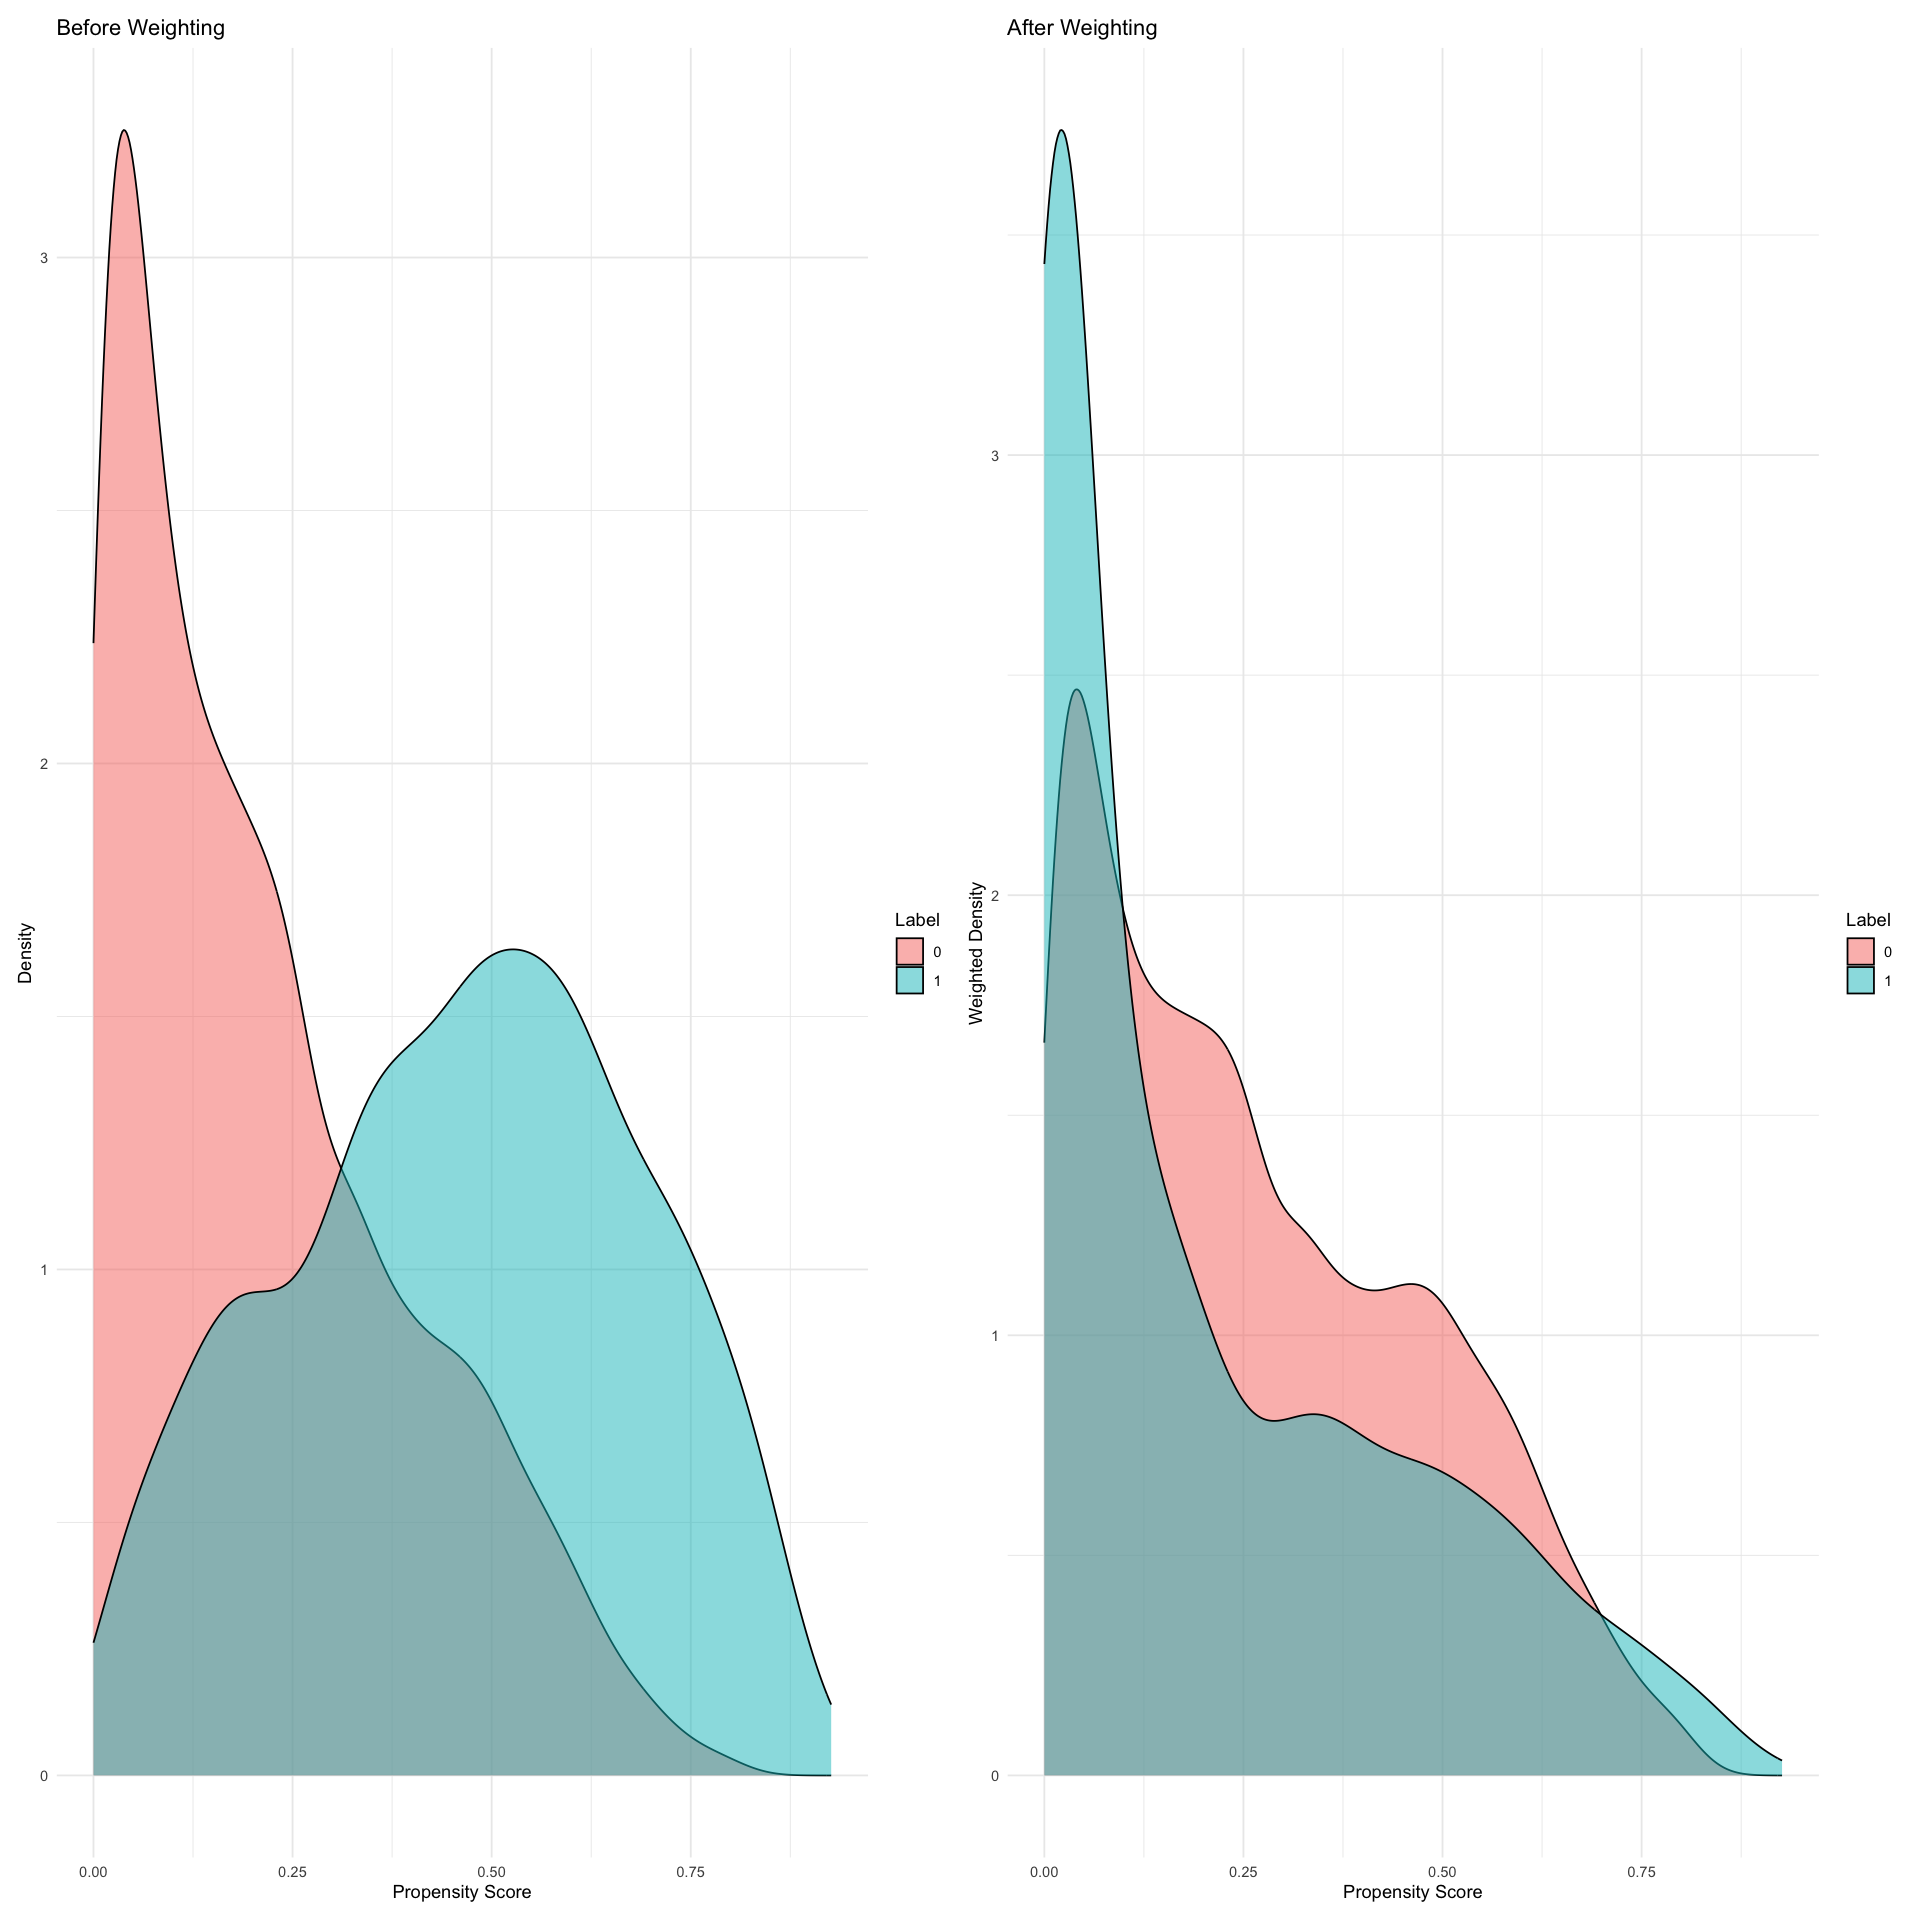

In [93]:
# Resize display for interactive use
options(repr.plot.width = 16, repr.plot.height = 16)

# Plot before weighting
plot_before <- ggplot(Df_regression_unique, aes(x = propensity_score, fill = as.factor(label))) +
  geom_density(alpha = 0.5) +
  labs(title = "Before Weighting", x = "Propensity Score", y = "Density", fill = "Label") +
  theme_minimal()

# Plot after weighting
plot_after <- ggplot(Df_regression_unique, aes(x = propensity_score, weight = weights, fill = as.factor(label))) +
  geom_density(alpha = 0.5) +
  labs(title = "After Weighting", x = "Propensity Score", y = "Weighted Density", fill = "Label") +
  theme_minimal()

# Combine plots side by side
combined_plot <- plot_before + plot_after

# Display the combined plot
combined_plot

# Save the combined plot
ggsave("combined_propensity_plots.png", plot = combined_plot, width = 12, height = 6, dpi = 300)


## Discussion
---
Propensity score methods are widely used in observational studies to address selection bias and confounding, particularly when randomized controlled trials (RCTs) are not feasible. Propensity scores estimate the probability of treatment (or exposure) assignment given observed covariates, enabling the creation of comparable groups.

## Key Concepts
---

### 1. Selection Bias:

In observational studies, treatment (or exposure) assignment is not random and may depend on patient or study characteristics.
Example: Smokers and non-smokers might differ systematically in age, socioeconomic status, or health conditions, which could confound the relationship between smoking and disease outcomes.

### 2. Confounding:

Confounders are variables related to both the exposure and the outcome that can distort the observed relationship.
Example: Age is both a determinant of smoking and a risk factor for heart disease.

### 3. Propensity Score Definition:

The propensity score is the conditional probability of being exposed to a treatment given a set of observed covariates:
 \begin{equation}
 e(X)= P \left( T = 1 | X\right)
 \end{equation}


Where : $\text{T}$ is the treatment indicator (1 = treated, 0 = untreated) and $\text{X}$ represents observed covariates.

## Rationale for Using Propensity Scores
---

### 1. Creating Comparable Groups

Propensity scores balance the distribution of observed covariates between treated and untreated groups, mimicking randomization. After adjustment, differences in outcomes can be more confidently attributed to the exposure rather than confounders.

### 2. Mitigating Selection Bias

By balancing observed covariates, propensity scores reduce selection bias due to systematic differences in treatment assignment.

### 3. Simplifying Multivariate Adjustment

Instead of adjusting for numerous covariates directly, propensity scores summarize the confounding information into a single scalar. This is particularly useful when dealing with many covariates or complex relationships.

### 4. Handling Covariate Imbalances
Propensity score methods ensure that treated and untreated groups are balanced with respect to observed covariates.
This reduces the risk of bias in estimating treatment effects.

### 5. Flexibility in Application

Propensity scores can be used with various methods, including:
- Matching: Pairing individuals with similar scores.
- Weighting: Applying inverse probability of treatment weights (IPTW).
- Stratification: Dividing the dataset into strata based on propensity scores.
- Covariate Adjustment: Including the propensity score as a covariate in regression models.

### 6. Transparency and Interpretability
Propensity scores allow researchers to visually and statistically assess balance across covariates using metrics like standardized mean differences or balance plots.
This provides clear evidence of how well the adjustment mitigates confounding.

## Effectiveness of Propensity Scores
---

### 1. Well-Balanced Covariates:

If propensity scores are correctly specified, covariates should be balanced across exposure groups after adjustment, ensuring comparability.

### 2. Reduces Bias from Observed Confounders:

Propensity scores account for observed confounders but cannot adjust for unmeasured confounding.


### 3. Avoids Model Overfitting:

By summarizing covariates into a single score, propensity scores reduce the risk of overfitting, especially in small samples.


## Limitations
---

### 1. Unmeasured Confounding:

Propensity scores only adjust for observed confounders. Bias due to unmeasured or unknown confounders may persist.


### 2. Positivity Violation:

Propensity score methods require overlap between treatment groups. If some covariate combinations only occur in one group, estimates may be unstable.


### 3. Dependence on Model Specification:

The quality of propensity score adjustment depends on correctly modeling the probability of treatment assignment.


### 4. No Replacement for Randomization:

Propensity scores mimic randomization for observed variables but cannot replicate the control over unobserved variables achieved in RCTs.

# Question 2: Love Plot for Covariate Balance
---

Implement a function that generates a Love plot to evaluate the balance of
covariates before and after applying propensity score weighting. Interpret the
plot and assess how well the weighting has succeeded in achieving balance
across the covariates.

---
<b> <font color='red'>Important Warning:</font> </b> Note that our values may differ depending on how we model the label, in the absence of a subject matter expert, I played it safe and placed the entire explanatory variables into the model, except for those features that are related to cancer:

glm( `label` ~ `age`+`gender_female`+`smoking_status`+`alcohol_assessment`+`bmi`+`chronic_obstructive_bronchitis`+`pneumonia`+`asthma`+`dvt`+`Followup`+`statin`+`asian`+`white`+`black`+`hawaiian`+`native`, 
                        binomial(link = "logit"), 
                        data = Df_regression_unique)
    
    
while other may limit the explanatory variables based on the advice of some experts, such as:

glm(`label`  ~ `statin` + `age` + `gender` + `race` + `smoking_status` + `alcohol` + `bmi` + `chronic_obstructive_bronchitis` + `pneumonia` + `asthma` + `dvt`, family = binomial(link = "logit"),data = Df_regression_unique)

## Step 8: Create Love plot
---
Documentation: https://cran.r-project.org/web/packages/cobalt/vignettes/love.plot.html

Warning message:
“Large mean differences detected; you may not be using standardized mean differences for continuous variables.”


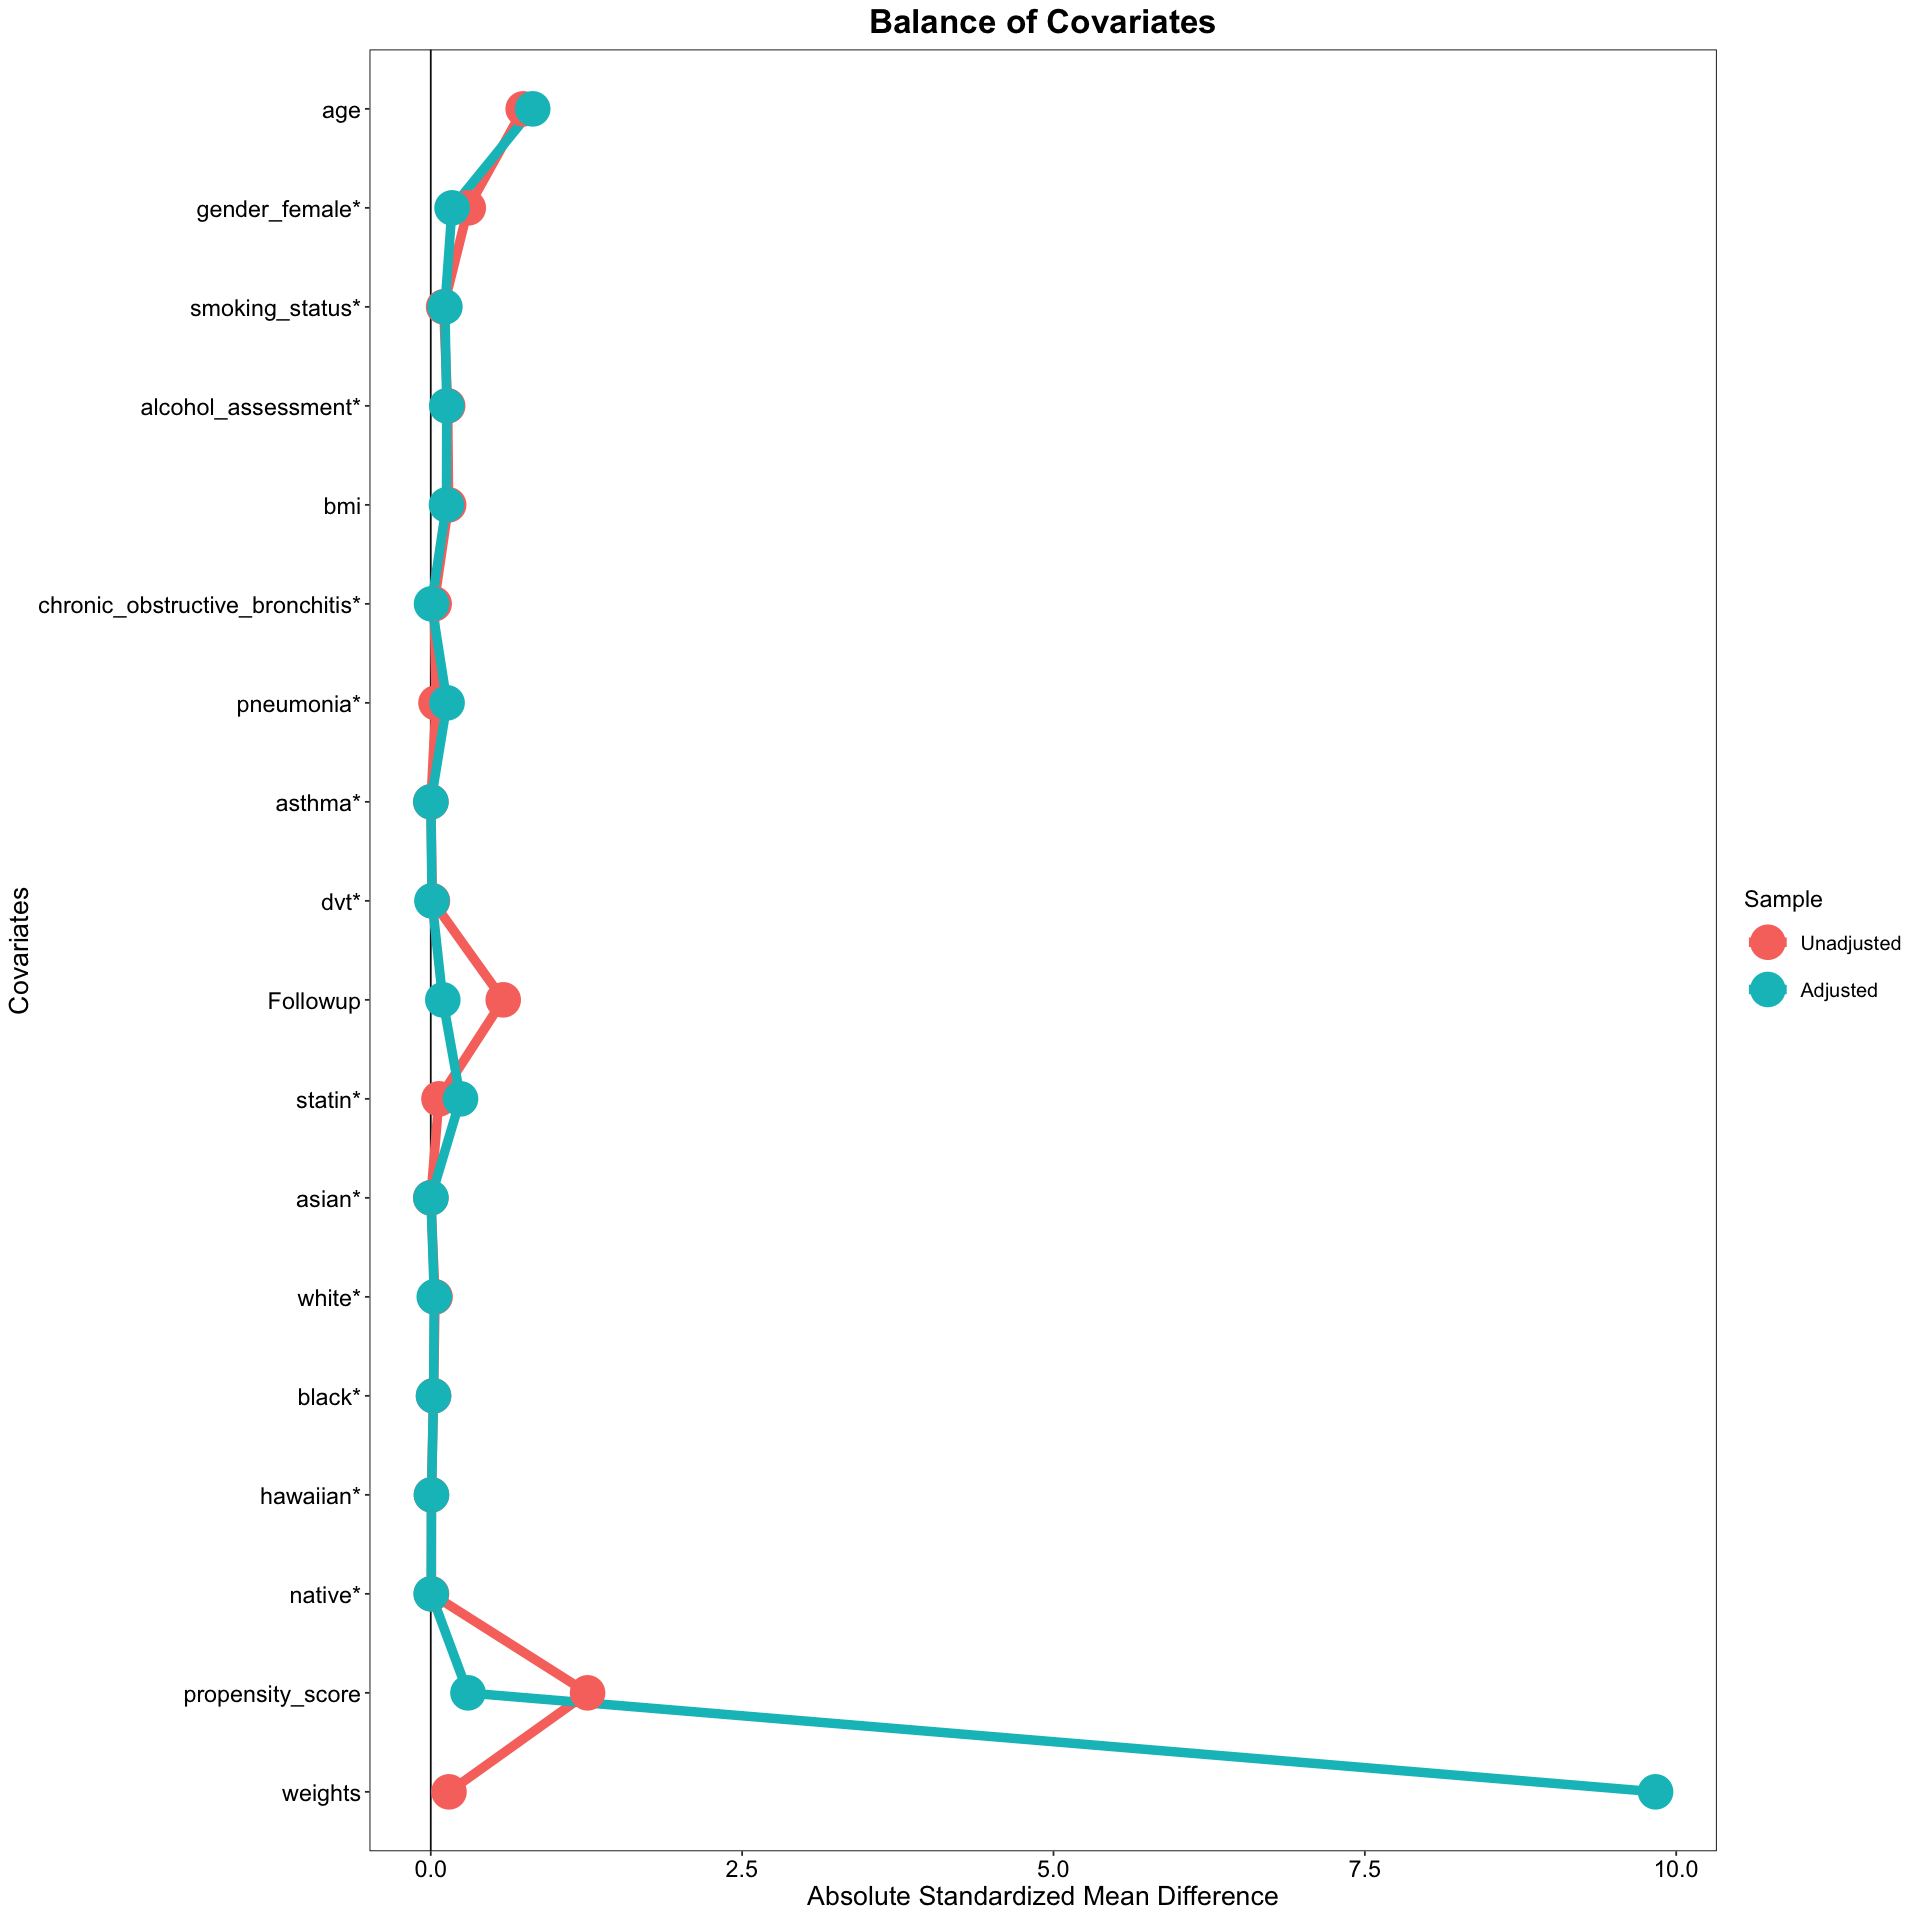

In [94]:
love.plot(
  bal,
  size = 10,
  text.size = 100,
  legend.size = 20,
    line=TRUE,
    stars="raw",
  abs = TRUE
) +
labs(
  title = "Balance of Covariates",
  x = "Absolute Standardized Mean Difference",
  y = "Covariates"
)+  theme(
    plot.title = element_text(size = 20, face = "bold"),   # Title text size
    axis.title.x = element_text(size = 16),               # X-axis title size
    axis.title.y = element_text(size = 16),               # Y-axis title size
    axis.text.x = element_text(size = 14),                # X-axis tick label size
    axis.text.y = element_text(size = 14),                # Y-axis tick label size
    legend.title = element_text(size = 14),               # Legend title size
    legend.text = element_text(size = 12),                # Legend text size
    strip.text = element_text(size = 16, face = "bold")   # Facet label size
  )

In [95]:
ggsave("love_plot_customized.png", plot = last_plot(), width = 10, height = 8, dpi = 300)

## Step 9: Save the preprocessed data as a .csv file (for the python users) and .R file (for the R users)

In [96]:
tail(Df_regression_unique)

,label,age,gender_female,smoking_status,alcohol_assessment,bmi,chronic_obstructive_bronchitis,pneumonia,asthma,dvt,⋯,no_cancer,stage4,stage1a,stage2a,stage3a,stage1b,stage2b,stage3b,propensity_score,weights
,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5933,0,53,1,0,1,29.66,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.01643594,1.016711
5934,0,70,0,1,1,30.06,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.60717267,2.545648
5935,0,70,0,0,1,31.07,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.16577225,1.198713
5936,1,75,0,0,1,29.60,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.40243932,2.484847
5937,0,59,0,0,1,27.30,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.24174875,1.318824
5938,0,46,1,1,1,27.60,0,0,0,0,⋯,1,0,0,0,0,0,0,0,0.01319190,1.013368


In [97]:
write.csv(Df_regression_unique, "cleaned_data_with_propensity_score.csv", row.names = FALSE)

In [98]:
save(Df_regression_unique, file = "cleaned_data_with_propensity_score.RData")